In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import sys
import io
from dataclasses import dataclass

try:
    import scipy.signal as sps
    from scipy.io import wavfile
    scipy_ok = True
except Exception:
    scipy_ok = False


In [23]:
# # -----------------------------
# # 1) Generate synthetic test audio with known F0
# # -----------------------------

# sr = 16000  # sample rate
# dur = 6.0   # seconds

# t = np.linspace(0, dur, int(sr*dur), endpoint=False)

# seg1 = (t >= 0) & (t < 2.0)
# seg2 = (t >= 2.0) & (t < 4.0)
# seg3 = (t >= 4.0) & (t < 6.0)

# f0_true = np.zeros_like(t)
# f0_true[seg1] = 120.0
# f0_true[seg2] = 120.0 + (t[seg2] - 2.0) * (220.0 - 120.0) / 2.0
# f0_true[seg3] = 180.0

# def synth(f0_track, sr, harmonics=8, noise_db=-20.0):
#     n = len(f0_track)
#     y = np.zeros(n, dtype=np.float64)
#     for k in range(1, harmonics+1):
#         dphi = 2*np.pi*(f0_track*k)/sr
#         yk = np.sin(np.cumsum(dphi))
#         y += (1.0/k) * yk
#     am = 1.0 + 0.1*np.sin(2*np.pi*2.0*t)
#     y *= am
#     if scipy_ok:
#         b, a = sps.butter(4, 0.45)
#         y = sps.filtfilt(b, a, y)
#     rms = np.sqrt(np.mean(y**2) + 1e-12)
#     noise = np.random.randn(n)
#     noise = noise / (np.sqrt(np.mean(noise**2))+1e-12)
#     noise_rms = rms * 10**(noise_db/20.0)
#     y_noisy = y + noise_rms * noise
#     y_noisy = y_noisy / (np.max(np.abs(y_noisy))+1e-12)
#     return y_noisy

# y = synth(f0_true, sr)

# wav_path = "/mnt/data/synthetic_f0_test.wav"
# try:
#     wavfile.write(wav_path, sr, (y * 0.95).astype(np.float32))
# except Exception:
#     wav_path = None

import librosa
y, sr = librosa.load("../data/interim/whistle.flac", sr=None, mono=True)


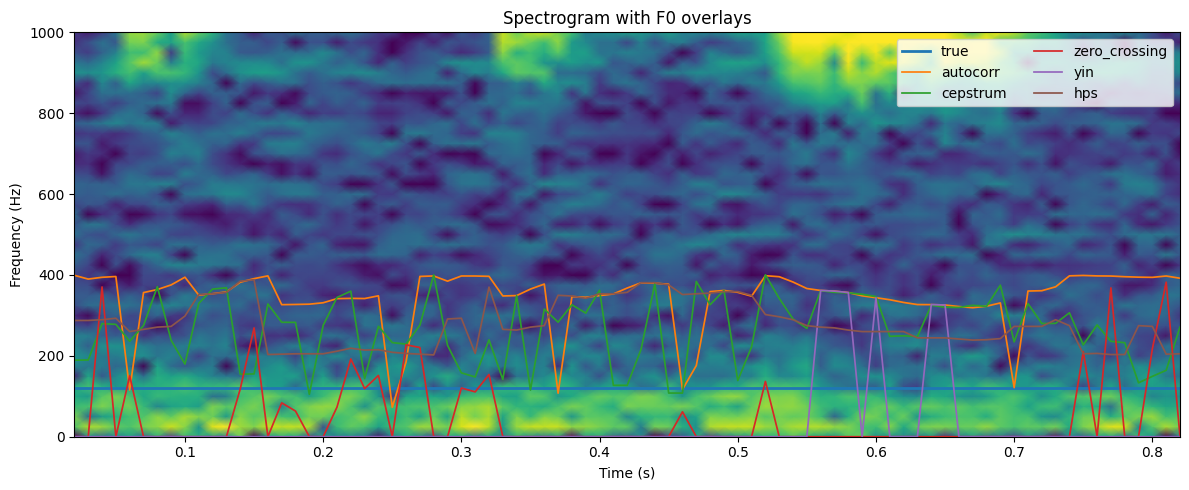

In [24]:
# -----------------------------
# 2) Framing and parameters
# -----------------------------
frame_ms = 40.0
hop_ms = 10.0
N = int(round(sr*frame_ms/1000.0))
H = int(round(sr*hop_ms/1000.0))

def frame_signal(x, N, H):
    n_frames = 1 + (len(x)-N)//H
    idx = np.tile(np.arange(N), (n_frames, 1)) + np.tile(np.arange(n_frames)*H, (N,1)).T
    return x[idx], n_frames

frames, n_frames = frame_signal(y, N, H)
times = (np.arange(n_frames)*H + N/2)/sr

f0_true_frames = np.zeros(n_frames)
for i in range(n_frames):
    s = i*H
    e = s+N
    e = min(e, len(f0_true))
    f0_true_frames[i] = np.median(f0_true[s:e])

if scipy_ok:
    win = sps.windows.hann(N, sym=False)
else:
    win = 0.5 - 0.5*np.cos(2*np.pi*np.arange(N)/N)

f0_min, f0_max = 60.0, 400.0
lag_min = int(np.floor(sr/f0_max))
lag_max = int(np.ceil(sr/f0_min))

# -----------------------------
# 3) Pitch methods
# -----------------------------
def parabolic_interpolation(x, i):
    if i <= 0 or i >= len(x)-1: return i, x[i]
    xl, xc, xr = x[i-1], x[i], x[i+1]
    denom = 2*(xl - 2*xc + xr)
    if abs(denom) < 1e-12: return i, xc
    delta = (xl - xr) / denom
    return i + delta, xc - 0.25*(xl - xr)*delta

def f0_autocorr(frame):
    x = frame * win
    x = x - np.mean(x)
    r = np.correlate(x, x, mode='full')[N-1:]
    r[:lag_min] = 0.0
    if r[0] > 0: r = r / (r[0] + 1e-12)
    i = np.argmax(r[lag_min:lag_max+1]) + lag_min
    p, _ = parabolic_interpolation(r, i)
    return sr/p if p > 0 else 0.0

def f0_cepstrum(frame):
    x = frame * win
    x = x + 1e-8*np.random.randn(len(x))
    spec = np.fft.rfft(x)
    log_mag = np.log(np.abs(spec) + 1e-12)
    ceps = np.fft.irfft(log_mag)
    q_min = int(np.floor(sr/f0_max))
    q_max = int(min(len(ceps)-1, np.ceil(sr/f0_min)))
    ceps_limited = np.copy(ceps)
    ceps_limited[:q_min] = 0.0; ceps_limited[q_max+1:] = 0.0
    i = np.argmax(ceps_limited[q_min:q_max+1]) + q_min
    p, _ = parabolic_interpolation(ceps_limited, i)
    return sr/p if p > 0 else 0.0

if scipy_ok:
    b_bp, a_bp = sps.butter(4, [50/(sr*0.5), 1000/(sr*0.5)], btype="band")

def f0_zero_crossing(frame):
    x = frame
    if scipy_ok: x = sps.filtfilt(b_bp, a_bp, x)
    sgn = np.sign(x); sgn[sgn==0] = 1
    crossings = np.where(np.diff(sgn) != 0)[0]
    if len(crossings) < 2: return 0.0
    intervals = np.diff(crossings[::2])
    if len(intervals) == 0: return 0.0
    T = np.median(intervals)/sr
    f0 = 1.0/T if T > 0 else 0.0
    return f0 if f0_min <= f0 <= f0_max else 0.0

def f0_hps(frame, max_harmonics=5):
    x = frame * win
    nfft = 2**int(np.ceil(np.log2(len(x)))+1)
    X = np.fft.rfft(x, n=nfft)
    mag = np.abs(X)
    freqs = np.fft.rfftfreq(nfft, d=1.0/sr)
    band = (freqs >= f0_min) & (freqs <= f0_max*max_harmonics)
    mag_band = mag[band]; freqs_band = freqs[band]
    if len(mag_band) == 0: return 0.0
    hps = mag_band.copy()
    for k in range(2, max_harmonics+1):
        dec = mag_band[::k]
        hps[:len(dec)] *= dec
    i = np.argmax(hps); f_est = freqs_band[i]
    f0 = f_est
    while f0 > f0_max: f0 *= 0.5
    return f0 if f0_min <= f0 <= f0_max else 0.0

def yin_diff_fn(x, max_tau):
    n = len(x); x = x - np.mean(x)
    size = 2**int(np.ceil(np.log2(2*n)))
    X = np.fft.rfft(x, n=size)
    S = X * np.conjugate(X)
    r = np.fft.irfft(S)[:n]
    d = r[0] + r[0] - 2*r
    return np.abs(d)[:max_tau+1]

def f0_yin(frame, thresh=0.1):
    x = frame * win; max_tau = lag_max
    d = yin_diff_fn(x, max_tau)
    cmnd = np.zeros_like(d); cmnd[0] = 1.0
    ssum = 0.0
    for tau in range(1, len(d)):
        ssum += d[tau]
        cmnd[tau] = d[tau] * tau / (ssum + 1e-12)
    tau = lag_min
    while tau < len(cmnd):
        if cmnd[tau] < thresh:
            tmin = tau
            while tmin+1 < len(cmnd) and cmnd[tmin+1] < cmnd[tmin]:
                tmin += 1
            inv = 1.0 - cmnd
            p, _ = parabolic_interpolation(inv, tmin)
            if p <= 0: break
            f0 = sr/p
            if f0_min <= f0 <= f0_max: return f0
            else: break
        tau += 1
    return 0.0

methods = {
    "autocorr": f0_autocorr,
    "cepstrum": f0_cepstrum,
    "zero_crossing": f0_zero_crossing,
    "yin": f0_yin,
    "hps": f0_hps,
}

est_tracks = {}
runtimes = {}
for name, fn in methods.items():
    start = time.time()
    f0_est = np.zeros(n_frames)
    for i in range(n_frames):
        f0_est[i] = fn(frames[i])
    runtimes[name] = (time.time() - start)
    est_tracks[name] = f0_est

# -----------------------------
# 4) Spectrogram with overlays
# -----------------------------
f, tt, S = sps.spectrogram(y, fs=sr, nperseg=N, noverlap=N-H, mode="magnitude", scaling="spectrum")
S_db = 20.0 * np.log10(S + 1e-12)
vmin = np.percentile(S_db, 5); vmax = np.percentile(S_db, 99)

plt.figure(figsize=(12, 5))
plt.pcolormesh(tt, f, S_db, shading="gouraud", vmin=vmin, vmax=vmax)
plt.ylabel("Frequency (Hz)"); plt.xlabel("Time (s)")
plt.title("Spectrogram with F0 overlays")
plt.ylim(0, min(1000, f[-1]))

plt.plot(times, f0_true_frames, linewidth=2, label="true")
for name, track in est_tracks.items():
    plt.plot(times, track, linewidth=1.25, label=name)

plt.legend(loc="upper right", ncol=2)
plt.tight_layout()
plt.show()


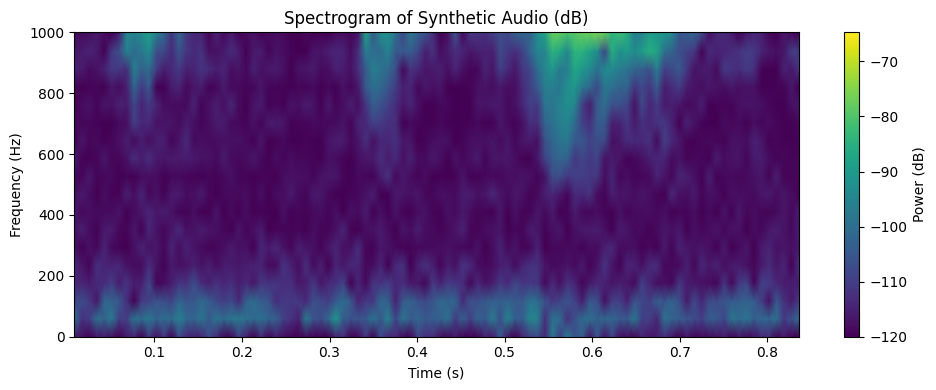

In [25]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.signal import spectrogram

f, t_spec, Sxx = spectrogram(y, sr, nperseg=512, noverlap=256)

plt.figure(figsize=(10, 4))
plt.pcolormesh(t_spec, f, 10 * np.log10(Sxx + 1e-12), shading='gouraud')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectrogram of Synthetic Audio (dB)")
plt.colorbar(label="Power (dB)")
plt.ylim(0, 1000)
plt.tight_layout()
plt.show()


In [26]:

# -----------------------------
# 5) Save artifacts
# -----------------------------
png_path = "../data/spectrogram_with_f0.png"
plt.gcf().savefig(png_path, dpi=150, bbox_inches="tight")

# Save CSVs
tracks = pd.DataFrame({"time_s": times, "f0_true": f0_true_frames})
for name, f0 in est_tracks.items():
    tracks[f"f0_{name}"] = f0
tracks_path = "../data/f0_tracks_and_metrics_overlay.csv"
tracks.to_csv(tracks_path, index=False)

print("Saved:")
print(f"- Spectrogram PNG: {png_path}")
print(f"- Tracks CSV: {tracks_path}")
if wav_path:
    print(f"- Audio WAV: {wav_path}")


Saved:
- Spectrogram PNG: ../data/spectrogram_with_f0.png
- Tracks CSV: ../data/f0_tracks_and_metrics_overlay.csv


<Figure size 640x480 with 0 Axes>